## Trying to make a better jump function with variable mid of sigmoid. 

In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt
from numpy import core
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap
from functions import *
from matplotlib.textpath import TextPath
from matplotlib.patches import PathPatch

In [2]:
# running conditions
TRIALS = 1000
DAYS = 61 # 60 days of learning and 1 day of testing
N_SYLL = 1
if N_SYLL > 5 or N_SYLL < 1:
    ValueError('Invalid number of syllables')
RANDOM_SEED = 13 # SEED 3 both jump and without jump learn 
print(f'Random seed is {RANDOM_SEED}')
np.random.seed(RANDOM_SEED)

Random seed is 13


In [3]:
# modes
SWITCHING = 0
ANNEALING = 1
ANNEALING_SLOPE = 4
ANNEALING_MID = 2
ANNEALING_MID_DECAY = 0.3 # exponential decay wrt days
HEBBIAN_LEARNING = True
LOG_NORMAL = False
balance_factor = 3
BG_influence = True

# parameters
REWARD_WINDOW = 10
BG_NOISE = 0.1

# Run paraneters
N_DISTRACTORS = 10
LEARING_RATE_RL = 0.1
LEARNING_RATE_HL = 2e-5 # small increase compared to CODE_8

# sigmoid layer parameters
BG_SIG_SLOPE = 2.5  # uniform output 
BG_sig_MID = 0
RA_SIG_SLOPE = 18 # most steep such that MC output is not skewed
RA_sig_MID = 0
# Sigmoid on MC is removed
# MC_SIG_SLOPE = 1 # 5 if lesser -> more difficult to climb the hill, assymptotes before 
# MC_sig_MID = 0

# layer sizes
HVC_SIZE = 100
BG_SIZE = 50
RA_SIZE = 100 
MC_SIZE = 2
N_RA_CLUSTERS = MC_SIZE
N_BG_CLUSTERS = 2

In [4]:
# Model
class NN:
    def __init__(self, hvc_size, bg_size, ra_size, mc_size):
        if LOG_NORMAL:
            self.W_hvc_bg = sym_lognormal_samples(minimum = -1, maximum = 1, size = (hvc_size, bg_size)) # changing from -1 to 1 
            self.W_hvc_ra = np.zeros((hvc_size, ra_size)) # connections start from 0 and then increase
            self.W_bg_ra = lognormal_weight((bg_size, ra_size)) # const from 0 to 1
            self.W_ra_mc = lognormal_weight((ra_size, mc_size)) # const from 0 to 1
        else:
            self.W_hvc_bg = np.random.uniform(-1,1,(hvc_size, bg_size)) # changing from -1 to 1 
            self.W_hvc_ra = np.zeros((hvc_size, ra_size)) # connections start from 0 and then increase
            self.W_bg_ra = np.random.uniform(0, 1, (bg_size, ra_size)) # const from 0 to 1
            self.W_ra_mc = np.random.uniform(0, 1, (ra_size, mc_size)) # const from 0 to 1
        # Creating channels
        # channel from ra to mc
        for i in range(N_RA_CLUSTERS):
            segPath = np.diag(np.ones(N_RA_CLUSTERS, int))[i]
            self.W_ra_mc[i*ra_size//N_RA_CLUSTERS : (i+1)*ra_size//N_RA_CLUSTERS] *= segPath
        # channel from bg to ra such that motor cortex components are independent of each other
        for i in range(N_BG_CLUSTERS):
            segPath = np.diag(np.ones(N_BG_CLUSTERS, int))[i]
            self.W_bg_ra[i*bg_size//N_BG_CLUSTERS : (i+1)*bg_size//N_BG_CLUSTERS] *= [j for j in segPath for r in range(RA_SIZE//N_BG_CLUSTERS)]

        self.hvc_size = hvc_size
        self.bg_size = bg_size
        self.ra_size = ra_size
        self.mc_size = mc_size  
        self.ra_cluster_size = ra_size // N_RA_CLUSTERS
        self.bg_cluster_size = bg_size // N_BG_CLUSTERS
        self.bg_influence = BG_influence
            
    def forward(self, hvc_array):
        self.hvc = hvc_array
        # count number of 1 in hvc, divide bg by that number
        num_ones = np.count_nonzero(hvc_array == 1)
        self.bg = new_sigmoid(np.dot(hvc_array/num_ones, self.W_hvc_bg) + np.random.normal(0, BG_NOISE, self.bg_size), m = BG_SIG_SLOPE, a = BG_sig_MID)
        self.ra = new_sigmoid(np.dot(self.bg, self.W_bg_ra/np.sum(self.W_bg_ra, axis=0)) * balance_factor * self.bg_influence + np.dot(hvc_array/num_ones, self.W_hvc_ra)* HEBBIAN_LEARNING, m = RA_SIG_SLOPE, a = RA_sig_MID) 
        self.mc = 1.5*np.dot(self.ra, self.W_ra_mc/np.sum(self.W_ra_mc, axis=0)) # outputs to +-0.50
        ''' even after BG cut off, output should remain still the same'''
        # below code is only for testing without sigmoidal functions
        # self.mc = new_sigmoid(np.dot(self.ra, self.W_ra_mc/np.sum(self.W_ra_mc, axis=0)), m = MC_SIG_SLOPE, a = MC_sig_MID)
        # self.bg = np.dot(hvc_array/num_ones, self.W_hvc_bg)  #outputs to +-0.98
        # self.ra = np.dot(self.bg, self.W_bg_ra/np.sum(self.W_bg_ra, axis=0)) * balance_factor  + np.dot(hvc_array/num_ones, self.W_hvc_ra)* HEBBIAN_LEARNING #outputs to +-0.40
        return self.mc, self.ra, self.bg

In [5]:
class Environment:
    def __init__(self, hvc_size, bg_size, ra_size, mc_size, seed):
        self.hvc_size = hvc_size
        self.bg_size = bg_size
        self.ra_size = ra_size
        self.mc_size = mc_size
        self.seed = seed
        self.model = NN(hvc_size, bg_size, ra_size, mc_size)
        # landscape parameters
        self.centers = np.random.uniform(-0.9, 0.9, (N_SYLL, 2))
        self.heights = np.random.uniform(0.2, 0.7, (N_SYLL, N_DISTRACTORS))
        self.means = np.random.uniform(-1, 1, (N_SYLL,N_DISTRACTORS, 2))
        self.spreads = np.random.uniform(0.1, 0.6, (N_SYLL, N_DISTRACTORS))
        # data storage
        self.rewards = np.zeros((DAYS, TRIALS, N_SYLL))
        self.actions = np.zeros((DAYS, TRIALS, N_SYLL, self.mc_size))
        self.hvc_bg_array = np.zeros((DAYS, TRIALS, N_SYLL))
        self.bg_out = np.zeros((DAYS, TRIALS, N_SYLL))
        self.hvc_ra_array = np.zeros((DAYS, TRIALS, N_SYLL))
        self.ra_out = np.zeros((DAYS, TRIALS, N_SYLL))
        self.RPE = np.zeros((DAYS, TRIALS, N_SYLL)) 
        self.RPE_SUM = np.zeros((DAYS, TRIALS, N_SYLL))
        self.ra_all = np.zeros((DAYS, TRIALS, N_SYLL, self.ra_size))
        self.dw_day_array = np.zeros((DAYS, N_SYLL))
        self.pot_array = np.zeros((DAYS, N_SYLL))
        self.annealing_mids = np.zeros((DAYS, TRIALS, N_SYLL))

        
    def get_reward(self, coordinates, syll):
        # landscape creation and reward calculation
        center = self.centers[syll, :]
        reward_scape = gaussian(coordinates, 1, center, 0.3)
        if N_DISTRACTORS == 0:
            return reward_scape
        hills = []
        hills.append(reward_scape)
        for i in range(N_DISTRACTORS):
            height = self.heights[syll, i]
            mean = self.means[syll, i,:]
            spread = self.spreads[syll, i]
            hills.append(gaussian(coordinates, height, mean, spread))
        return np.maximum.reduce(hills)
     
    def run(self, learning_rate, learning_rate_hl, annealing = False):
        # modes 
        self.annealing = annealing
        self.model.bg_influence = True
        # each day, 1000 trial, n_syll syllables
        for day in tqdm(range(DAYS)):
            dw_day = np.zeros(N_SYLL)
            self.model.bg_influence = True
            if day >= DAYS-1: 
                self.model.bg_influence = False # BG lesion on the last day
            if SWITCHING == True:
                if day >= 15:
                    self.annealing = True
                else:
                    self.annealing = False  
            sum_RPE = 0
            for iter in range(TRIALS):
                for syll in range(N_SYLL):
                    # input from HVC is determined by the syllable
                    input_hvc = np.zeros(HVC_SIZE)
                    input_hvc[syll] = 1
                    # reward, action and baseline
                    action, ra, bg = self.model.forward(input_hvc)
                    reward = self.get_reward(action, syll)
                    self.rewards[day, iter, syll] = reward
                    self.actions[day, iter, syll,:] = action
                    reward_baseline = 0
                    if iter < REWARD_WINDOW and iter > 0:
                        reward_baseline = np.mean(self.rewards[day, :iter, syll])
                    elif iter >= REWARD_WINDOW:
                        reward_baseline = np.mean(self.rewards[day, iter-REWARD_WINDOW:iter, syll])
                    # Updating weights
                    # RL update
                    dw_hvc_bg = learning_rate*(reward - reward_baseline)*input_hvc.reshape(self.hvc_size,1)*self.model.bg * self.model.bg_influence # RL update
                    self.model.W_hvc_bg += dw_hvc_bg
                    # HL update
                    dw_hvc_ra = learning_rate_hl*input_hvc.reshape(self.hvc_size,1)*self.model.ra*HEBBIAN_LEARNING # lr is supposed to be much smaller here
                    self.model.W_hvc_ra += dw_hvc_ra
                    # bound weights between +-1
                    # np.clip(self.model.W_hvc_bg, -1, 1, out = self.model.W_hvc_bg)
                    # np.clip(self.model.W_hvc_ra, -1, 1, out = self.model.W_hvc_ra)
                    np.core.umath.maximum(np.core.umath.minimum(self.model.W_hvc_bg, 1, out = self.model.W_hvc_bg), -1, out = self.model.W_hvc_bg) # type: ignore
                    np.core.umath.maximum(np.core.umath.minimum(self.model.W_hvc_ra, 1, out = self.model.W_hvc_ra), -1, out = self.model.W_hvc_ra) # type: ignore
                    # storing values for plotting
                    self.RPE[day, iter, syll] = reward - reward_baseline        
                    sum_RPE += reward - reward_baseline 
                    self.RPE_SUM[day, iter, syll] = sum_RPE
                    dw_day[syll] += np.mean(np.abs(dw_hvc_bg))
                    self.hvc_bg_array[day, iter, syll] = self.model.W_hvc_bg[syll,1]
                    self.bg_out[day, iter, syll] = bg[1]
                    self.hvc_ra_array[day, iter, syll] = self.model.W_hvc_ra[syll,1]
                    self.ra_out[day, iter, syll] = ra[0]
                    self.ra_all[day, iter, syll, :] = ra

            # if day % 1 == 0:   
            #     tqdm.write(f'Day: {day}, Action: {action}, Reward: {reward}, Reward Baseline: {reward_baseline}')  
            # Annealing
            if self.annealing:
                for syll in range(N_SYLL):
                    ''' input daily sum, output scaling factor for potentiation'''
                    # calculating potentiation 
                    d = dw_day[syll]*100 # scaling up to be comparable
                    annealing_mid_final = ANNEALING_MID*np.exp(-ANNEALING_MID_DECAY*day/60)
                    self.annealing_mids[day, :, syll] = annealing_mid_final*np.ones_like(self.annealing_mids[day, :, syll])
                    p = 1 * sigmoid(1*d, m = annealing_mid_final, a = ANNEALING_MID)
                    potentiation_factor = np.zeros((self.hvc_size))
                    potentiation_factor[syll] = 1-p 
                    # implementing night weight changes
                    night_noise = np.random.uniform(-1, 1, self.bg_size) # make it lognormal
                    dw_night = LEARING_RATE_RL*potentiation_factor.reshape(self.hvc_size,1)*night_noise*10*self.model.bg_influence
                    self.model.W_hvc_bg += dw_night
                    self.model.W_hvc_bg = (self.model.W_hvc_bg + 1) % 2 -1 # bound between -1 and 1 in cyclical manner
                    # storing values
                    self.pot_array[day, syll] = 1-p
                    self.dw_day_array[day, syll] = d
                
    def generate_trajectory(self, syll):
        x_traj, y_traj = zip(*self.actions[:,:, syll,:].reshape(-1, 2))
        limit = 1.5
        x, y = np.linspace(-limit, limit, 50), np.linspace(-limit, limit, 50)
        X, Y = np.meshgrid(x, y)
        Z = self.get_reward([X, Y], syll)
        return X,Y,Z, x_traj, y_traj, syll    
    
    def plot_trajectory(self, X, Y, Z, x_traj, y_traj, syll):
        fig, axs = plt.subplots(figsize=(10, 9))
        path = TextPath((0, 0), f'Syllable: {syll}', size=12)
        patch = PathPatch(path)
        # generate grid 
        limit = 1.5
        # Plot contour
        cmap = LinearSegmentedColormap.from_list('white_to_green', ['white', 'green'])
        contour = axs.contourf(X, Y, Z, levels=10, cmap=cmap)
        fig.colorbar(contour, ax=axs, label='Reward')
        
        # plot trajectory
        axs.plot(x_traj[::10], y_traj[::10], 'r', label='Agent Trajectory', alpha = 0.5, linewidth = 0.5) # Plot every 20th point for efficiency
        axs.scatter(x_traj[0], y_traj[0], s=20, c='b', label='Starting Point')  # Plot first point as red circle
        axs.scatter(x_traj[-5:], y_traj[-5:], s=20, c='r', marker='x', label='Ending Point') # type: ignore
        axs.scatter(self.centers[syll, 0], self.centers[syll, 1], s=20, c='y', marker='x', label='target')  # type: ignore
        # labels
        axs.set_title(f'Contour plot of reward function SEED:{RANDOM_SEED} syllable: {syll}')   
        axs.set_xlabel('x')
        axs.set_ylabel('y')
        axs.legend()
        plt.tight_layout()
        plt.show()

    def generate_results(self, syll):   
        return self.ra_all[:,:,syll,:].reshape(DAYS*TRIALS, self.ra_size)
        
    def plot_results(self, syll):
        fig, axs = plt.subplots(6, 1, figsize=(10, 15))
        axs[0].plot(self.rewards[:,:,syll].reshape(DAYS*TRIALS), '.', markersize=1, linestyle='None')
        axs[0].hlines(0.7, 0, DAYS*TRIALS, colors='r', linestyles='dashed')
        axs[0].set_ylim(0, 1)
        axs[0].set_ylabel('Reward')
        axs[1].plot(self.hvc_bg_array[:,:,syll].reshape(DAYS*TRIALS))
        axs[1].set_ylim(-1, 1)
        axs[1].set_ylabel('HVC BG weights')
        axs[2].plot(self.bg_out[:,:,syll].reshape(DAYS*TRIALS),'.', markersize=0.5, linestyle='None')
        axs[2].set_ylim(-1, 1)
        axs[2].set_ylabel('BG output')
        axs[3].plot(self.hvc_ra_array[:,:,syll].reshape(DAYS*TRIALS))
        axs[3].set_ylim(-1, 1)
        axs[3].set_ylabel('HVC RA weights')
        axs[4].plot(self.actions[:,:,syll,0].reshape(DAYS*TRIALS))
        axs[4].plot(self.actions[:,:,syll,1].reshape(DAYS*TRIALS))
        axs[4].plot(self.centers[syll, 0]*np.ones(TRIALS*DAYS))
        axs[4].plot(self.centers[syll, 1]*np.ones(TRIALS*DAYS))
        axs[4].legend(['x target', 'y target'])
        axs[4].set_ylabel('Motor Output')
        axs[4].set_ylim(-1, 1)
        axs[5].plot(self.ra_out[:,:,syll].reshape(DAYS*TRIALS))
        axs[5].set_ylim(-1, 1)
        axs[5].set_ylabel('RA activity')
        fig.suptitle('Results', fontsize=20)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    
    def plot_dw_day(self, syll):
        if ANNEALING:
            fig, axs = plt.subplots(4,1,figsize=(10, 15))
            expanded_dw_day_array = np.zeros((DAYS*TRIALS, N_SYLL))
            expanded_pot_array = np.zeros((DAYS*TRIALS, N_SYLL))
            # Expand dw_day_array and pot_array to match the size of rewards
            expanded_dw_day_array = np.repeat(self.dw_day_array[:, syll], DAYS*TRIALS// len(self.dw_day_array[:, syll]))
            expanded_pot_array = np.repeat(self.pot_array[:, syll], DAYS*TRIALS// len(self.pot_array[:, syll]))
            fig.suptitle(f'Annealing SEED:{RANDOM_SEED} syllable: {syll}')
            axs[0].set_title(f'Annealing SEED:{RANDOM_SEED} syllable: {syll}')  
            axs[0].plot(expanded_dw_day_array, markersize=1, label='dW_day')
            axs[0].set_ylim(0,10)
            axs[0].set_ylabel('dW_day')        
            axs[1].plot(expanded_pot_array, markersize=1, label='Potentiation factor')
            axs[1].set_ylabel('Potentiation factor')
            axs[2].plot(self.rewards[:,:,syll].reshape(DAYS*TRIALS), '.', markersize=1, label='Reward', alpha = 0.1)
            axs[2].set_ylabel('Rewards')
            axs[2].set_ylim(0, 1)
            axs[3].plot(self.RPE[:,:,syll].reshape(DAYS*TRIALS), '.', markersize=1, label='RPE', alpha = 0.1)               
            axs[3].set_ylabel('RPE')
            axs[3].set_ylim(-1, 1)
            for i in range(4):
                axs[i].vlines(range(0, DAYS*TRIALS, TRIALS), -3, 10, colors='b', linestyles='dashed')           
            plt.tight_layout()
            plt.show()

            
            # plt.plot(expanded_dw_day_array, markersize=1, label='dW_day')
            # plt.plot(expanded_pot_array, markersize=1, label='Potentiation factor')
            # plt.plot(self.rewards[:,:,syll].reshape(DAYS*TRIALS), '.', markersize=1, label='Reward', alpha = 0.1)
            # plt.xlabel('Days')
            # plt.ylabel('dW_day')
            # plt.legend()
            # plt.show()  
        
    def save_trajectory(self, syll):
        fig, axs = plt.subplots(figsize=(10, 9))
        # generate grid 
        x, y = np.linspace(-1, 1, 50), np.linspace(-1, 1, 50)
        X, Y = np.meshgrid(x, y)
        Z = self.get_reward([X, Y], syll)
        # Plot contour
        cmap = LinearSegmentedColormap.from_list('white_to_green', ['white', 'green'])
        contour = axs.contourf(X, Y, Z, levels=10, cmap=cmap)
        fig.colorbar(contour, ax=axs, label='Reward')
        
        # plot trajectory
        x_traj, y_traj = zip(*self.actions[:,:, syll,:].reshape(-1, 2))
        axs.plot(x_traj[::10], y_traj[::10], 'r', label='Agent Trajectory', alpha = 0.5, linewidth = 0.5) # Plot every 20th point for efficiency
        axs.scatter(x_traj[0], y_traj[0], s=20, c='b', label='Starting Point')  # Plot first point as red circle
        axs.scatter(x_traj[-5:], y_traj[-5:], s=20, c='r', marker='x', label='Ending Point') # type: ignore
        axs.scatter(self.centers[syll, 0], self.centers[syll, 1], s=20, c='y', marker='x', label='target')  # type: ignore
        # labels
        axs.set_title(f'Contour plot of reward function SEED:{RANDOM_SEED} syllable: {syll}')
        axs.set_xlabel('x')
        axs.set_ylabel('y')
        axs.legend()
        plt.tight_layout()
        # Create the "plots" directory if it doesn't exist
        os.makedirs(save_dir, exist_ok = True)
        # Clear previous plots (optional):
        # for filename in os.listdir(save_dir):
        #     if filename.startswith("trajectory") and filename.endswith(".png") or filename.endswith(".jpg"):
        #         os.remove(os.path.join(save_dir, filename))
        # Save the plot
        plt.savefig(os.path.join(save_dir, f"trajectory_{RANDOM_SEED}_{syll}.png"))
        plt.close()  # Close the plot to avoid memory leaks
        
    def save_results(self, syll):
        fig, axs = plt.subplots(6, 1, figsize=(10, 15))
        axs[0].plot(self.rewards[:,:,syll].reshape(DAYS*TRIALS), '.', markersize=1, linestyle='None')
        axs[0].hlines(0.7, 0, DAYS*TRIALS, colors='r', linestyles='dashed')
        axs[0].set_ylim(0, 1)
        axs[0].set_ylabel('Reward')
        axs[1].plot(self.hvc_bg_array[:,:,syll].reshape(DAYS*TRIALS))
        axs[1].set_ylim(-1, 1)
        axs[1].set_ylabel('HVC BG weights')
        axs[2].plot(self.bg_out[:,:,syll].reshape(DAYS*TRIALS),'.', markersize=0.5, linestyle='None')
        axs[2].set_ylim(-1, 1)
        axs[2].set_ylabel('BG output')
        axs[3].plot(self.hvc_ra_array[:,:,syll].reshape(DAYS*TRIALS))
        axs[3].set_ylim(-1, 1)
        axs[3].set_ylabel('HVC RA weights')
        axs[4].plot(self.actions[:,:,syll,0].reshape(DAYS*TRIALS))
        axs[4].plot(self.actions[:,:,syll,1].reshape(DAYS*TRIALS))
        axs[4].plot(self.centers[syll, 0]*np.ones(TRIALS*DAYS))
        axs[4].plot(self.centers[syll, 1]*np.ones(TRIALS*DAYS))
        axs[4].legend(['x target', 'y target'])
        axs[4].set_ylabel('Motor Output')
        axs[4].set_ylim(-1, 1)
        axs[5].plot(self.ra_out[:,:,syll].reshape(DAYS*TRIALS))
        axs[5].set_ylim(-1, 1)
        axs[5].set_ylabel('RA activity')
        fig.suptitle(f'Results SEED:{RANDOM_SEED} syllable: {syll}', fontsize=20)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        # Create the "plots" directory if it doesn't exist
        os.makedirs(save_dir, exist_ok = True)
        # Clear previous plots (optional):
        # for filename in os.listdir(save_dir):
        #     if filename.startswith("results") and filename.endswith(".png") or filename.endswith(".jpg"):
        #         os.remove(os.path.join(save_dir, filename))
        # Save the plot
        plt.savefig(os.path.join(save_dir, f"results_{RANDOM_SEED}_{syll}.png"))
        plt.close()  # Close the plot to avoid memory leaks
        
    def save_dw_day(self, syll):
        if ANNEALING:
            expanded_dw_day_array = np.zeros((DAYS*TRIALS, N_SYLL))
            expanded_pot_array = np.zeros((DAYS*TRIALS, N_SYLL))
            # Expand dw_day_array and pot_array to match the size of rewards
            expanded_dw_day_array = np.repeat(self.dw_day_array[:, syll], DAYS*TRIALS// len(self.dw_day_array[:, syll]))
            expanded_pot_array = np.repeat(self.pot_array[:, syll], DAYS*TRIALS// len(self.pot_array[:, syll]))
            plt.title(f'Annealing SEED:{RANDOM_SEED} syllable: {syll}')
            plt.plot(expanded_dw_day_array, markersize=1, label='dW_day')
            plt.plot(expanded_pot_array, markersize=1, label='Potentiation factor')
            plt.plot(self.rewards[:,:,syll].reshape(DAYS*TRIALS), '.', markersize=1, label='Reward', alpha = 0.1)
            plt.xlabel('Days')
            plt.ylabel('dW_day')
            plt.legend()
            # Create the "plots" directory if it doesn't exist
            os.makedirs(save_dir, exist_ok = True)
            # # Clear previous plots (optional):
            # for filename in os.listdir(save_dir):
            #     if filename.startswith("dw") and filename.endswith(".png") or filename.endswith(".jpg"):
            #         os.remove(os.path.join(save_dir, filename))
            # Save the plot
            plt.savefig(os.path.join(save_dir, f"dw_{RANDOM_SEED}_{syll}.png"))
            plt.close()  # Close the plot to avoid memory leaks         
    

In [6]:
env = Environment(HVC_SIZE, BG_SIZE, RA_SIZE, MC_SIZE, RANDOM_SEED)
env.run(LEARING_RATE_RL, LEARNING_RATE_HL, ANNEALING)
# remove_prev_files()
for i in range(N_SYLL):
    X, Y, Z, x_traj, y_traj, syll = env.generate_trajectory(i)



100%|██████████| 61/61 [00:04<00:00, 12.78it/s]


In [7]:
def plot_trajectory(X, Y, Z, x_traj, y_traj, syll):
    fig, axs = plt.subplots(figsize=(10, 9))
    limit = 1.5
    cmap = LinearSegmentedColormap.from_list('white_to_green', ['white', 'black'])
    contour = axs.contourf(X, Y, Z, levels=10, cmap=cmap)
    fig.colorbar(contour, ax=axs, label='Reward')
    # plot trajectory
    axs.plot(x_traj[::10], y_traj[::10], 'yellow', label='Agent Trajectory', alpha = 0.1, marker = ".", linewidth = 0, markersize = 0.99) # Plot every 20th point for efficiency
    axs.scatter(x_traj[0], y_traj[0], s=100, c='blue', label='Starting Point', marker = 'x')  # type: ignore # Plot first point as red circle
    axs.scatter(x_traj[-1001], y_traj[-1001], s=100, c='pink', marker='x', label='Before Lesion Ending Point')
    axs.scatter(x_traj[-5:], y_traj[-5:], s=100, c='r', marker='x', label='After Leison Point') # type: ignore
    axs.scatter(env.centers[syll, 0], env.centers[syll, 1], s=100, c='green', marker='x', label='target')  # type: ignore
    # labels
    axs.set_title(f'Contour plot of reward function SEED:{RANDOM_SEED} syllable: {syll}')
    axs.set_ylabel(r'$P_{\alpha}$')
    axs.set_xlabel(r'$P_{\beta}$')
    axs.legend()
    plt.tight_layout()
    plt.show()

expanded_dw_day = np.zeros((DAYS*TRIALS))
def plot_dw_day(syll):
    if ANNEALING:
        fig, axs = plt.subplots(5,1,figsize=(6, 10))
        expanded_dw_day_array = np.zeros((DAYS*TRIALS, N_SYLL))

        expanded_pot_array = np.zeros((DAYS*TRIALS, N_SYLL))

        # Expand dw_day_array and pot_array to match the size of rewards
        expanded_dw_day_array = np.repeat(env.dw_day_array[:, syll], DAYS*TRIALS// len(env.dw_day_array[:, syll]))
        expanded_dw_day = expanded_dw_day_array.reshape(DAYS*TRIALS)
        expanded_pot_array = np.repeat(env.pot_array[:, syll], DAYS*TRIALS// len(env.pot_array[:, syll]))
        fig.suptitle(f'Annealing SEED:{RANDOM_SEED} syllable: {syll}')
        axs[0].plot(expanded_dw_day_array, markersize=1, label='dW_day')
        axs[0].plot(env.annealing_mids[:,:,syll].reshape(DAYS*TRIALS))
        axs[0].set_ylabel('dW_day = mean(abs(dw_hvc_bg))')         
        axs[0].set_ylim(0,9) 
        axs[1].plot(expanded_pot_array, markersize=1, label='Potentiation factor')
        axs[1].set_ylabel('Size of night jump')
        axs[1].set_ylim(0, 1)
        axs[2].plot(env.rewards[:,:,syll].reshape(DAYS*TRIALS), '.', markersize=1, label='Reward', alpha = 0.1)
        axs[2].set_ylabel('Rewards')
        axs[2].set_ylim(0, 1)
        axs[3].plot(env.RPE[:,:,syll].reshape(DAYS*TRIALS), '.', markersize=1, label='RPE', alpha = 0.1)               
        axs[3].set_ylabel('RPE')
        axs[3].set_ylim(-1, 1)
        axs[4].plot(env.RPE_SUM[:,:,syll].reshape(DAYS*TRIALS), '.', markersize=1, label='RPE_SUM', alpha = 0.1)
        axs[4].set_ylabel('RPE sum for a day')
        axs[4].set_ylim(-1, 4)    
        for i in range(5):
            axs[i].vlines(range(0, DAYS*TRIALS, TRIALS), -3, 10, colors='black', linestyles='dashed', alpha = 0.1)           
        plt.tight_layout()
        plt.show()


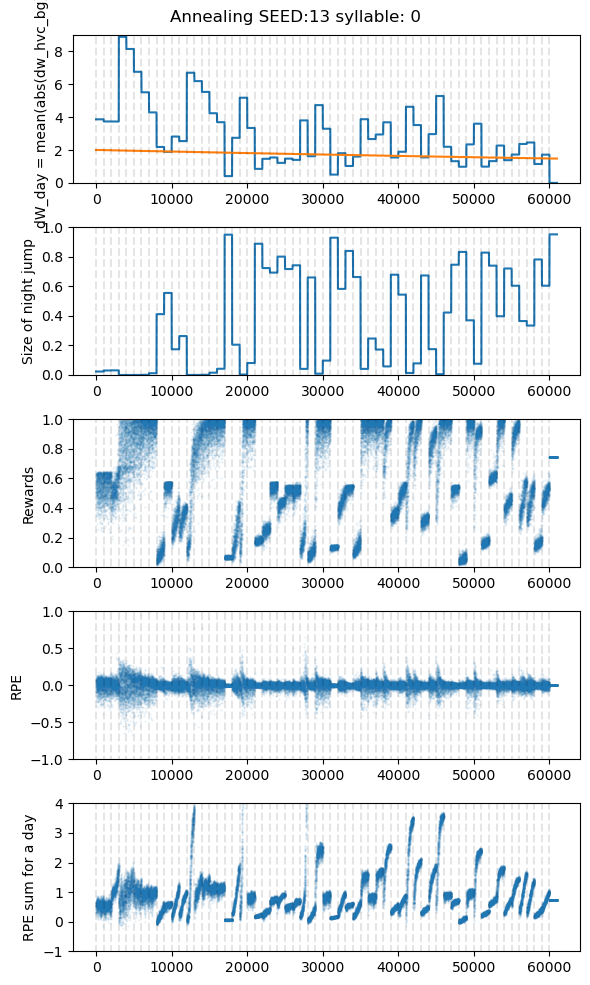

(61000,)
(61000,)
Correlations
nan
Correlation between Reward and sum RPE: 0.6126412298997606


/home/atharvsagar/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/atharvsagar/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [8]:
# plot_trajectory(X, Y, Z, x_traj, y_traj, syll) 
plot_dw_day(0)
print(expanded_dw_day.reshape(DAYS*TRIALS).shape)
print(env.rewards[:,:,syll].reshape(DAYS*TRIALS).shape)
print("Correlations")
print(np.corrcoef(env.rewards[:,:,0].reshape(DAYS*TRIALS), expanded_dw_day)[0,1])    
print(f"Correlation between Reward and sum RPE: {np.corrcoef(env.rewards[:,:,0].reshape(DAYS*TRIALS), env.RPE_SUM[:,:,0].reshape(DAYS*TRIALS))[0,1]}")                   
# ra_all = env.generate_results(i)
# env.plot_results(i)


# def build_and_run(seed, annealing, plot):
#     tqdm.write(f" Random seed is {seed}")
#     np.random.seed(seed)
#     env = Environment(HVC_SIZE, BG_SIZE, RA_SIZE, MC_SIZE, RANDOM_SEED)
#     env.run(LEARING_RATE_RL, LEARNING_RATE_HL, ANNEALING)
#     remove_prev_files()
#     for i in range(N_SYLL):
#         env.save_trajectory(i)
#         env.save_results(i)
#         if ANNEALING:
#             env.save_dw_day(i)
#     return np.mean(env.rewards[:,-100:], axis=1)

In [9]:
print(env.rewards[(DAYS-1)*TRIALS-100:(DAYS-1)*TRIALS])
rewards = env.rewards[:,:,0].reshape(DAYS*TRIALS)
np.mean(rewards[(DAYS-1)*TRIALS-100:(DAYS-1)*TRIALS])
print(np.mean(rewards[(DAYS-1)*TRIALS-100:(DAYS-1)*TRIALS]))
print(np.mean(rewards[(DAYS)*TRIALS-100:(DAYS)*TRIALS]))        

[]
0.5384792403865721
0.7455736696238745


In [10]:
# print(ra_all.shape)
# # color plot ra_all 
# plt.figure(figsize=(5, 10)) 
# plt.title('RA activity')
# plt.xlabel('Iterations')
# plt.ylabel('Neurons')       
# plt.imshow(ra_all.T, vmin = -1, vmax = 1, cmap = 'coolwarm', aspect = 'auto')


In [11]:
if ANNEALING == False:
    ra_all_nojump = ra_all[:15*1000]
print(ra_all_nojump.shape)  # type: ignore
# color plot ra_all 
fig, axs = plt.subplots()
axs.pcolormesh(ra_all_nojump.T, vmin = -1, vmax = 1, cmap = 'coolwarm')
plt.title('RA activity')
plt.xlabel('Iterations')
plt.ylabel('Neurons')
plt.show()

NameError: name 'ra_all_nojump' is not defined

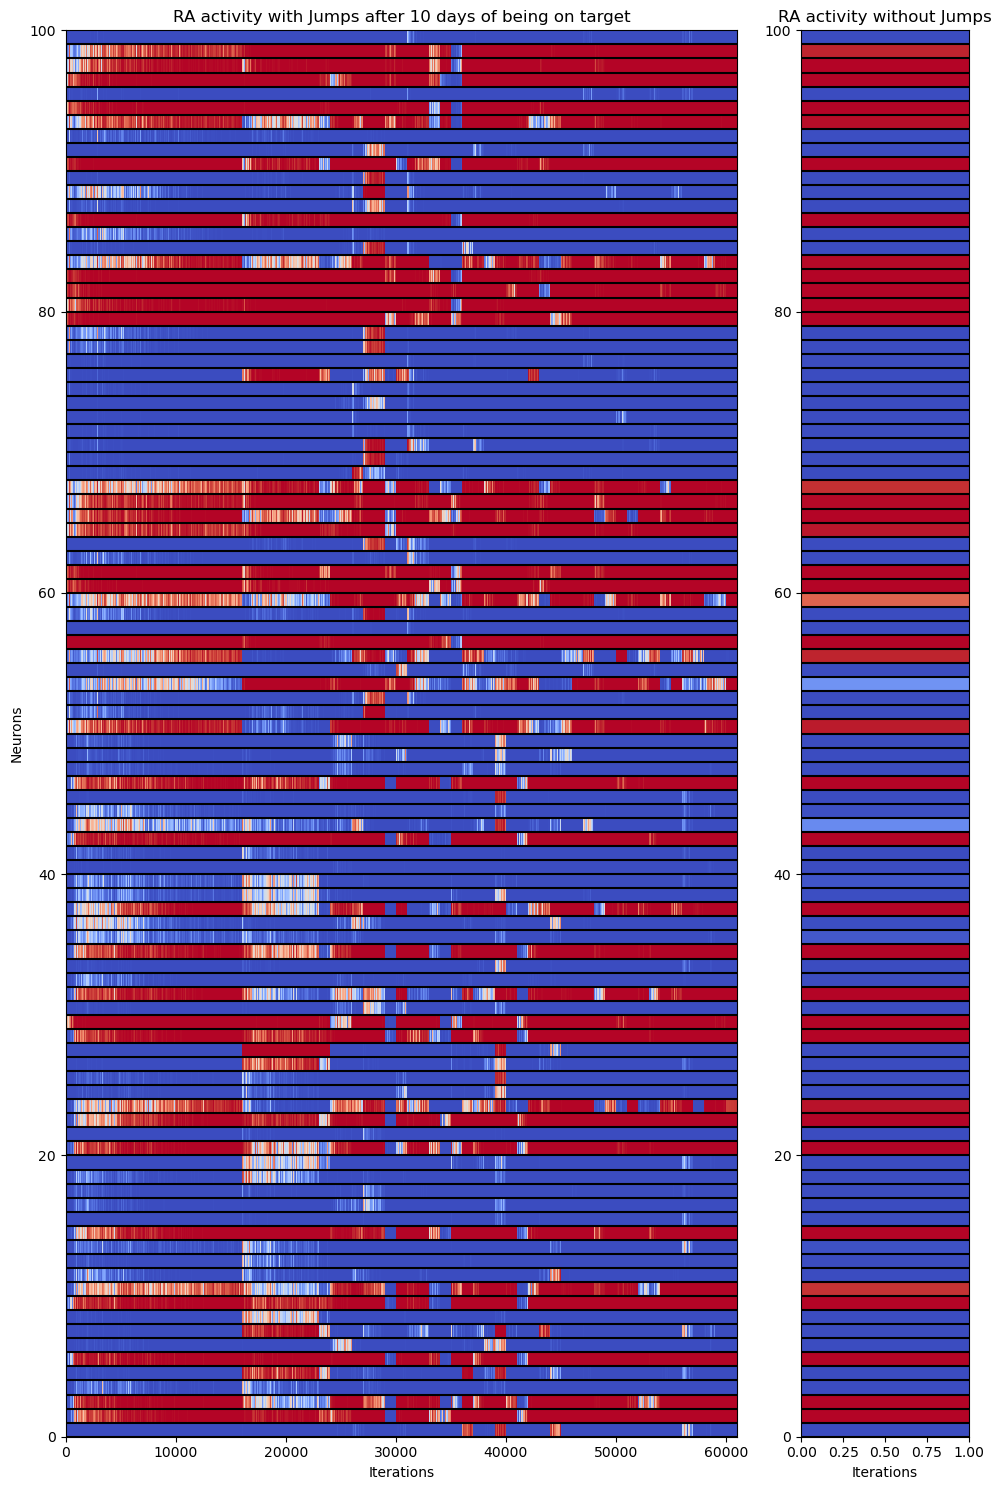

In [ ]:
# subplot ra_all and ra_all_nojump beside each other
fig, axs = plt.subplots(1, 2, figsize=(10, 15), gridspec_kw={'width_ratios': [4, 1]}) 
axs[0].pcolormesh(ra_all.T, vmin = -1, vmax = 1, cmap = 'coolwarm')
axs[0].hlines(range(0, 100, 1), 0, 61000, colors='black')
axs[0].set_title('RA activity with Jumps after 10 days of being on target') 
axs[0].set_xlabel('Iterations')     
axs[0].set_ylabel('Neurons')            
axs[1].pcolormesh(ra_all_nojump[-1:,:].T, vmin = -1, vmax = 1, cmap = 'coolwarm')
axs[1].hlines(range(0, 100, 1), 0, 1, colors='black')
axs[1].set_title('RA activity without Jumps')         
axs[1].set_xlabel('Iterations')                                
plt.tight_layout()              
plt.show()

In [ ]:


ra_all_vector = ra_all[-1,:]
ra_all_nojump_vector = ra_all_nojump[-1,:]
np.dot(ra_all_vector, ra_all_nojump_vector) / (np.linalg.norm(ra_all_vector) * np.linalg.norm(ra_all_nojump_vector))


NameError: name 'ra_all_nojump' is not defined

In [ ]:
dot_products.shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
def mc_func(ra, w_ra_mc):
    return 1.5*np.dot(ra, w_ra_mc/np.sum(w_ra_mc, axis=0))

def simulated_annealing(W_RA_MC, MC, RA_SIZE, T_initial, cooling_rate, max_iter):
    RA = np.random.choice([-1, 1], RA_SIZE)
    energies = []   
    def energy(RA):
        # return np.linalg.norm(MC - mc_func(RA, W_RA_MC))**2
        return  1 - env.get_reward(mc_func(RA, W_RA_MC), 0)

    T = T_initial
    for i in range(max_iter):
        
        energies.append(energy(RA)) 
        new_RA = RA.copy()
        index = np.random.randint(RA_SIZE)
        new_RA[index] *= -1

        delta_E = energy(new_RA) - energy(RA)
        if delta_E <= 0 or np.random.rand() < np.exp(-delta_E / T):
            RA = new_RA
        T *= cooling_rate
        if energy(RA) < 0.01:
            break

    return RA, energies


In [ ]:

# # Example usage
# mc = np.array([env.centers[syll, 0], env.centers[syll, 1]])
# w_ra_mc = env.model.W_ra_mc
# ra, energies= simulated_annealing(w_ra_mc, mc, RA_SIZE, 1000, 0.999, 5000)
# fig, axs = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [4, 1]})    
# axs[0].plot(energies)
# axs[0].set_title('Energy')
# axs[0].set_xlabel('Iterations')
# axs[0].set_ylabel('Energy')
# axs[1].imshow(ra.reshape(-1, 1), cmap='coolwarm', aspect='auto')
# axs[1].set_title('RA activity')
# axs[1].set_xlabel('Neurons')
# plt.tight_layout()
# plt.show()
# mc_pred = mc_func(ra, w_ra_mc)
# # different subplot
# plt.figure()
# fig, axs = plt.subplots(figsize=(7, 7))
# # generate grid 
# limit = 1.5
# # Plot contour
# cmap = LinearSegmentedColormap.from_list('white_to_green', ['white', 'green'])
# contour = axs.contourf(X, Y, Z, levels=10, cmap=cmap)
# fig.colorbar(contour, ax=axs, label='Reward')
# axs.scatter(mc_pred[0], mc_pred[1], s=20, c='y', marker='x', label='predicted target')  # type: ignore
# axs.scatter(env.centers[syll, 0], env.centers[syll, 1], s=20, c='r', marker='x', label='target')  # type: ignore
# # labels
# axs.set_title(f'Contour plot of reward function SEED:{RANDOM_SEED} syllable: {syll}')   
# axs.set_xlabel('x')
# axs.set_ylabel('y')
# axs.legend()
# plt.tight_layout()
# plt.show()
# mc_pred = mc_func(ra, w_ra_mc)
# # mc_pred, mc
# # subplot ra_all and ra_all_nojump beside each other
# fig, axs = plt.subplots(1, 3, figsize=(10, 15), gridspec_kw={'width_ratios': [4, 1, 1]})
# # overall title
# fig.suptitle('Comparison of Neural Activity with and without Jumps', fontsize=16)

# axs[0].imshow(ra_all.T, vmin=-1, vmax=1, cmap='coolwarm', aspect='auto')
# axs[0].set_title('with Jumps')
# axs[0].set_xlabel('Iterations')
# axs[0].set_ylabel('Neurons')
# axs[1].imshow(ra_all_nojump[-2:, :].T, vmin=-1, vmax=1, cmap='coolwarm', aspect='auto')
# axs[1].set_title('without Jumps')
# axs[1].set_xlabel('Iterations')
# axs[2].imshow(ra.reshape(RA_SIZE, 1), vmin=-1, vmax=1, cmap='coolwarm', aspect='auto')
# axs[2].set_title('simulated annealing')
# plt.subplots_adjust(wspace=0)
# plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make space for the suptitle
# plt.show()
